In [89]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import torch.nn.functional as F
import torch.optim as optim
import glob

In [84]:
from thulac import thulac
thu = thulac(seg_only=True)

class MyDataset():
        
    def __init__(self):
        self.category_lines = {0: [], 1: [], 2: [], 3: [], 4: []}
        self.word_vec = self.load_word_vector()
        self.vector_dim = 300
        
    def load_word_vector(self, in_name='data/sgns.financial.word'):
        """
        加载ACL2018词向量
        """
        word_vec = {}
        print('加载词向量中 ...')
        for i, line in enumerate(open(in_name)):
            if i <= 1:
                continue
            if i > 250000:
                break
            words = line.strip().split(' ')
            word = words[0]
#             print(word)
            word_vec[word] = np.array([float(num) for num in words[1:]])
    #         except UnicodeDecodeError:
    #             print("编码问题，行 {}".format(i))
        print('加载词完成！一共 {}个词'.format(len(word_vec)))
        return word_vec

    def load(self):
        """
        加载原始文本
        """
        print('加载原始文本中 ...')
        for in_name in glob.glob('data/labelled/*.txt'):
            for i, line in enumerate(open(in_name)):
                if line.strip() == '':
                    continue
                label = line.split('\t')[0]
                # 1234：四种情绪，-：没有情绪，x：不确定
                if label in ['1', '2', '3', '4', '-']:
                    if label == '-' or label == 'x':
                        y = int('0')
                    else:
                        y = int(label)
                self.category_lines[y].append(line.split('\t')[1].strip())
                       
    def line_to_tensor(self, line):
        """
        一句话转向量
        """
        list_vec = []
        for w in thu.cut(line): # 对分词结果进行处理
            w = w[0]
            if w in self.word_vec:
                list_vec.append([self.word_vec[w]])
        if list_vec:
            _tensor = torch.as_tensor(list_vec)
            return 1, _tensor
        else:
            return 0, None
    

dataset = MyDataset()
dataset.load()

for i in range(0, 5):
    print('num of category {}: {}'.format(i, len(dataset.category_lines[i])))

Model loaded succeed
加载词向量中 ...
加载词完成！一共 249933个词
加载原始文本中 ...
num of category 0: 4021
num of category 1: 2558
num of category 2: 2439
num of category 3: 2736
num of category 4: 1241


In [97]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
     
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return tensor(torch.zeros(1, self.hidden_size)).float()

In [98]:
all_categories = [0, 1, 2, 3, 4]

rnn = RNN(300, 128, 5)
bingo, input = dataset.line_to_tensor('对这样的市场，我彻底绝望了')
hidden = torch.zeros(1, 128)
print('input size =', input.size(), input[0].size(), hidden.size())
output, next_hidden = rnn(input[0].float(), hidden.float())
print(output)

def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(category_from_output(output))

input size = torch.Size([8, 1, 300]) torch.Size([1, 300]) torch.Size([1, 128])
tensor([[-1.6741, -1.5772, -1.5789, -1.6282, -1.5922]], grad_fn=<LogSoftmaxBackward>)
(1, 1)


In [102]:
import random

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(dataset.category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    bingo, line_tensor = dataset.line_to_tensor(line)
    if bingo:
        return category, line, category_tensor, line_tensor.float()
    else:
        return random_training_example()

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)

category = 3 / line = 中国中铁怎么不分红啊，我都执有2年了
category = 4 / line = 目前打压基本到位，最多仅仅存在理论上二毛钱的下跌空间
category = 3 / line = 等着分点红利呀 套这么深
category = 3 / line = 看到吧里这么多唱多我就呵呵了，今天应该会回调到21以下，上午赶紧能跑就跑吧
category = 4 / line = 今天没跑的明天要赔大钱了！我只说真话！
category = 1 / line = 603826套路太深A股什么时候才能真正与国际接轨国内石油价格稳居世界高位，中国A股熊霸全球一路向下。为什么差距这么大呢!什么时候A股才能雄霸天下，国内石油价格一路低位。那时就是盛世中国。
category = 3 / line = 吧里那个吃吃没有事干，把陈年旧事老是翻出来。
category = 3 / line = 牛散明晶逃跑了，我们散户站在高岗上了
category = 3 / line = 要是随便买一只都最少20个点啦！浪费多少时间啊，实在是伤心。
category = 0 / line = 这票主力筹码不够。收盘15.15


In [100]:
# 设置参数
input_size, hidden_size, output_size = 300, 128, 5
learning_rate = 1e-5
EPOCH = 5000

# 定义函数
rnn = RNN(input_size, hidden_size, output_size)

# 优化器
# optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [111]:
import time
import math

n_iters = 1000000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 0% (0m 15s) 1.6536 一天算白玩了，回到起点了。 / 0 ✗ (3)
10000 1% (0m 30s) 1.5807 价跌量增初主跌 下跌有量续下行 / 4 ✗ (3)
15000 1% (0m 46s) 1.6357 不要理会机构的出货 后面会有很多投资者长线买入的 / 3 ✗ (4)
20000 2% (1m 1s) 1.8382 抄了海峡的底哈哈！庄家你怎么办？接着打我？还是抬着我走路？ / 1 ✗ (2)
25000 2% (1m 17s) 1.5883 等跌到2元1或以下 这股吧就该安静了............................... / 0 ✗ (3)
30000 3% (1m 32s) 1.5321 今天应该是一个涨停的节奏！ / 2 ✓
35000 3% (1m 47s) 1.6240 千盼万盼还要等一个月等得也大久了 / 3 ✗ (0)
40000 4% (2m 2s) 1.5049 海润还有补跌需求，其他股已经腰斩。海润还将继续下探. / 1 ✓
45000 4% (2m 17s) 1.4741 净资产不到3元，利润不到1角，100元都敢买，你以为还有比你傻的人接盘？？？？ / 1 ✓
50000 5% (2m 33s) 1.6488 完蛋了，等待大幅回调，等低点。 / 0 ✗ (3)
55000 5% (2m 48s) 1.5473 逆转涨停 洗盘是庄家阴谋 不要中了庄的圈套 / 3 ✗ (4)
60000 6% (3m 4s) 1.6913 你妈勒个B又在画心电图了，又是玩老套路真他好无聊狗日的没得点新花样。 / 2 ✗ (1)
65000 6% (3m 20s) 1.6126 这时的妖股应该成为资金的避风港 / 3 ✗ (2)
70000 7% (3m 35s) 1.6426 王府井资产优良，经营稳健，转型力度大，步伐快，关键是手上现金多，扩张底气充足，收购冲动强烈，历年来给投资者红利回报也多。这样的公司在A股稀少，完全值得长期持有，市场终究会给世界第二大经济体的零售巨头合理的估值。坐等三年到500亿估值 / 0 ✗ (2)
75000 7% (3m 50s) 1.8039 快，速度抢进，不然没时间了，真的，赶紧吧，谢师傅，你赶紧补点，不然后悔终身……这个时候应该把老婆都压进去，三个月翻五个老婆出

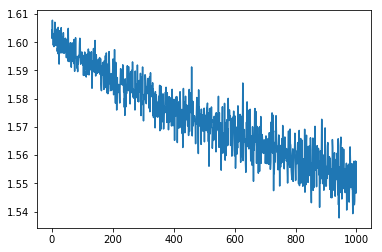

In [112]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

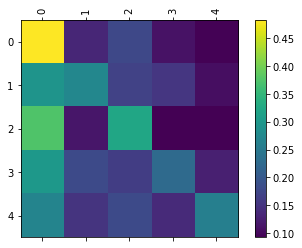

In [113]:
# Keep track of correct guesses in a confusion matrix
n_categories = 5
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()